In [1]:
import uproot
import ROOT

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('bmh')

Welcome to JupyROOT 6.14/00


In [6]:
import numpy as np

def extract_teffi(eff):
    _ = ROOT.TCanvas()
    eff.Draw()
    ROOT.gPad.Update()
    
    tot = eff.GetTotalHistogram()
    nBins = tot.GetNbinsX()
    xx = np.array([tot.GetXaxis().GetBinCenter(i)                 for i in range(1, nBins+1)])
    yy = np.array([eff.GetEfficiency(eff.GetGlobalBin(i))         for i in range(1, nBins+1)])
    yl = np.array([eff.GetEfficiencyErrorLow(eff.GetGlobalBin(i)) for i in range(1, nBins+1)])
    yu = np.array([eff.GetEfficiencyErrorUp(eff.GetGlobalBin(i))  for i in range(1, nBins+1)])
    
    return {'x': xx,
            'y': yy,
            'yerr': np.array([yu, yl])}

In [52]:
def extract_tprof(prof):
    nBins = prof.GetNbinsX()
    xx  = np.array([prof.GetXaxis().GetBinCenter(i) for i in range(1, nBins+1)])
    yy  = np.array([prof.GetBinContent(i)           for i in range(1, nBins+1)])
    err = np.array([prof.GetBinError(i)             for i in range(1, nBins+1)])
    
    return {'x': xx,
            'y': yy,
            'yerr': err}

## displacedStandAloneMuons

In [2]:
# tree = uproot.open('../Firefighter/washAOD/test/SIDMmumu_Mps-200_MZp-1p2_ctau-1p2_100k.root')['RECO_muTrackEffi/recoEffiForMuTrack']
# df = tree.pandas.df()

from collections import OrderedDict

dfs_dsa = OrderedDict({
    0.1 : uproot.open('../Firefighter/washAOD/test/2018/SIDMmumu_Mps-200_MZp-1p2_ctau-1p20e-03.root')['RECO_dsa/recoEffiForMuTrack'].pandas.df(),
      1 : uproot.open('../Firefighter/washAOD/test/2018/SIDMmumu_Mps-200_MZp-1p2_ctau-0p012.root'   )['RECO_dsa/recoEffiForMuTrack'].pandas.df(),
     10 : uproot.open('../Firefighter/washAOD/test/2018/SIDMmumu_Mps-200_MZp-1p2_ctau-0p12.root'    )['RECO_dsa/recoEffiForMuTrack'].pandas.df(),
     50 : uproot.open('../Firefighter/washAOD/test/2018/SIDMmumu_Mps-200_MZp-1p2_ctau-0p6.root'     )['RECO_dsa/recoEffiForMuTrack'].pandas.df(),
    100 : uproot.open('../Firefighter/washAOD/test/2018/SIDMmumu_Mps-200_MZp-1p2_ctau-1p2.root'     )['RECO_dsa/recoEffiForMuTrack'].pandas.df(),
    300 : uproot.open('../Firefighter/washAOD/test/2018/SIDMmumu_Mps-200_MZp-1p2_ctau-3p6.root'     )['RECO_dsa/recoEffiForMuTrack'].pandas.df()
})

In [3]:
for k, df in dfs_dsa.items():
    df.columns = [x.decode() for x in df.columns]

0.10cm #events: 49379
1.00cm #events: 42237
10.00cm #events: 41593
50.00cm #events: 46931
100.00cm #events: 50910
300.00cm #events: 47659


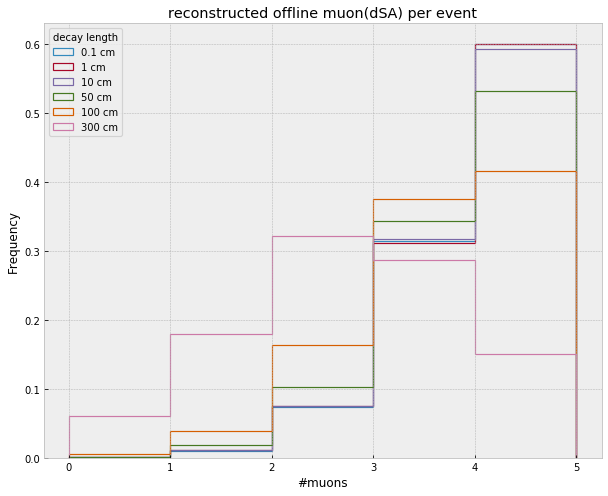

In [4]:
fig, ax = plt.subplots(figsize=(10,8))
plt.rcParams['patch.linewidth'] = 1.2

for k, df in dfs_dsa.items():
    df['nMatched'].plot.hist(bins=5, range=(0,5), ax=ax, label=f'{k} cm', histtype='step', density=True)
    print('%.2fcm #events: %i' % (k, len(df['nMatched'].dropna())))
ax.set_xlabel('#muons')
plt.title('reconstructed offline muon(dSA) per event')
plt.legend(loc='upper left', title='decay length')

Take a look at one of the samples

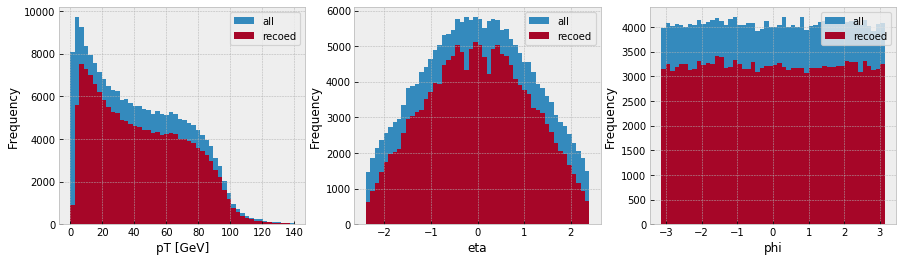

In [5]:
fig, ax = plt.subplots(1,3, figsize=(15,4))

df = dfs_dsa[100]

recoDf = df[['genPt','genEta','genPhi', 'recoPt']].dropna()

df['genPt']    .plot.hist(bins=50, range=(0,140), ax=ax[0], label='all')
recoDf['genPt'].plot.hist(bins=50, range=(0,140), ax=ax[0], label='recoed')
ax[0].set_xlabel('pT [GeV]')

df['genEta']    .plot.hist(bins=50, range=(-2.4,2.4), ax=ax[1], label='all')
recoDf['genEta'].plot.hist(bins=50, range=(-2.4,2.4), ax=ax[1], label='recoed')
ax[1].set_xlabel('eta')

df['genPhi']    .plot.hist(bins=50, ax=ax[2], label='all')
recoDf['genPhi'].plot.hist(bins=50, ax=ax[2], label='recoed')
ax[2].set_xlabel('phi')

for a in ax: a.legend(loc='best')

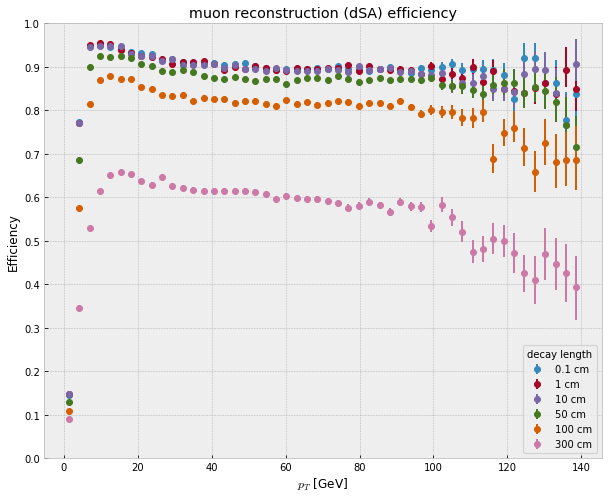

In [7]:

fig,ax = plt.subplots(figsize=(10,8))
# df = dfs[1]
for k, df in dfs_dsa.items():
    recoDf = df[['genPt', 'recoPt']].dropna()
    h0 = ROOT.TH1F(f'h0_{k}', '', 50,0,140)
    h1 = ROOT.TH1F(f'h1_{k}', '', 50,0,140)
    for x in df['genPt']: h0.Fill(x)
    for x in recoDf['genPt']: h1.Fill(x)
    
    eff = ROOT.TEfficiency(h1, h0)
    data = extract_teffi(eff)

    ax.errorbar(x=data['x'], y=data['y'], yerr=data['yerr'], fmt='o', label=f'{k} cm')

ax.set_title('muon reconstruction (dSA) efficiency')
ax.set_xlabel('$p_{T}$ [GeV]')
ax.set_ylabel('Efficiency')
ax.yaxis.set_major_locator(plt.MaxNLocator(10))
ax.set_ylim((0,1))
ax.legend(loc='best', title='decay length')

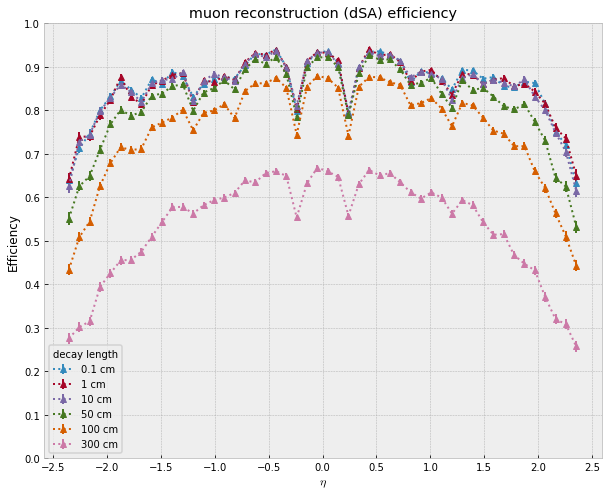

In [63]:
fig,ax = plt.subplots(figsize=(10,8))

for k, df in dfs_dsa.items():
    recoDf = df[['genEta', 'recoEta']].dropna()
    h0 = ROOT.TH1F(f'h0_{k}', '', 50,-2.4,2.4)
    h1 = ROOT.TH1F(f'h1_{k}', '', 50,-2.4,2.4)
    for x in df['genEta']: h0.Fill(x)
    for x in recoDf['genEta']: h1.Fill(x)
    
    eff = ROOT.TEfficiency(h1, h0)
    data = extract_teffi(eff)

    ax.errorbar(x=data['x'], y=data['y'], yerr=data['yerr'], fmt='^:', label=f'{k} cm')

ax.set_title('muon reconstruction (dSA) efficiency')
ax.set_xlabel('$\eta$')
ax.set_ylabel('Efficiency')
ax.xaxis.set_major_locator(plt.MaxNLocator(12))
ax.yaxis.set_major_locator(plt.MaxNLocator(10))
ax.set_ylim((0,1))
ax.legend(loc='best', title='decay length')

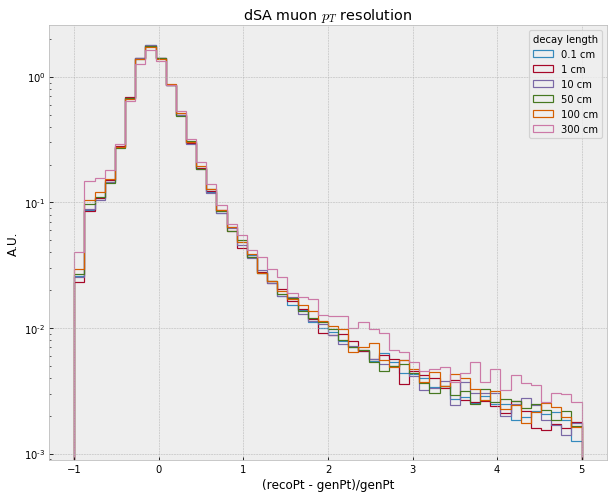

In [10]:
fig,ax = plt.subplots(figsize=(10,8))
# df = dfs[1]
for k, df in dfs_dsa.items():
    recoDf = df[['genPt', 'recoPt']].dropna()
    recoDf['reso'] = (recoDf['recoPt'] - recoDf['genPt']) / recoDf['genPt']
    recoDf['reso'].plot.hist(bins=50,range=(-1.,5), label=f'{k} cm', histtype='step',density=True)

ax.set_title('dSA muon $p_{T}$ resolution')
ax.set_xlabel('(recoPt - genPt)/genPt')
ax.set_ylabel('A.U.')
ax.set_yscale('log')
ax.legend(loc='best', title='decay length')

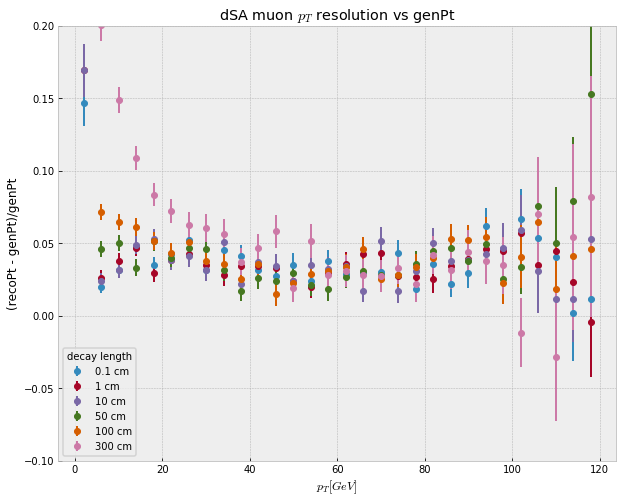

In [65]:
fig,ax = plt.subplots(figsize=(10,8))

for k, df in dfs_dsa.items():
    recoDf = df[['genPt', 'recoPt']].dropna()
    recoDf['reso'] = (recoDf['recoPt'] - recoDf['genPt']) / recoDf['genPt']
    _p = ROOT.TProfile(f'p_{k}', '', 30,0,120,-1,8)
    for index, row in recoDf.iterrows(): _p.Fill(row['genPt'], row['reso'])
    data = extract_tprof(_p)
    ax.errorbar(x=data['x'], y=data['y'], yerr=data['yerr'], label=f'{k} cm', fmt='o')

ax.set_title('dSA muon $p_{T}$ resolution vs genPt')
ax.set_xlabel('$p_{T} [GeV]$')
ax.set_ylabel('(recoPt - genPt)/genPt')
ax.set_ylim((-0.1,0.2))
ax.legend(loc='best', title='decay length')

## displacedGlobalMuons

In [11]:
dfs_dgm = OrderedDict({
    0.1 : uproot.open('../Firefighter/washAOD/test/2018/SIDMmumu_Mps-200_MZp-1p2_ctau-1p20e-03.root')['RECO_dgm/recoEffiForMuTrack'].pandas.df(),
      1 : uproot.open('../Firefighter/washAOD/test/2018/SIDMmumu_Mps-200_MZp-1p2_ctau-0p012.root'   )['RECO_dgm/recoEffiForMuTrack'].pandas.df(),
     10 : uproot.open('../Firefighter/washAOD/test/2018/SIDMmumu_Mps-200_MZp-1p2_ctau-0p12.root'    )['RECO_dgm/recoEffiForMuTrack'].pandas.df(),
     50 : uproot.open('../Firefighter/washAOD/test/2018/SIDMmumu_Mps-200_MZp-1p2_ctau-0p6.root'     )['RECO_dgm/recoEffiForMuTrack'].pandas.df(),
    100 : uproot.open('../Firefighter/washAOD/test/2018/SIDMmumu_Mps-200_MZp-1p2_ctau-1p2.root'     )['RECO_dgm/recoEffiForMuTrack'].pandas.df(),
    300 : uproot.open('../Firefighter/washAOD/test/2018/SIDMmumu_Mps-200_MZp-1p2_ctau-3p6.root'     )['RECO_dgm/recoEffiForMuTrack'].pandas.df()
})

In [12]:
for k, df in dfs_dgm.items():
    df.columns = [x.decode() for x in df.columns]

0.10cm #events: 49379
1.00cm #events: 42237
10.00cm #events: 41593
50.00cm #events: 46931
100.00cm #events: 50910
300.00cm #events: 47659


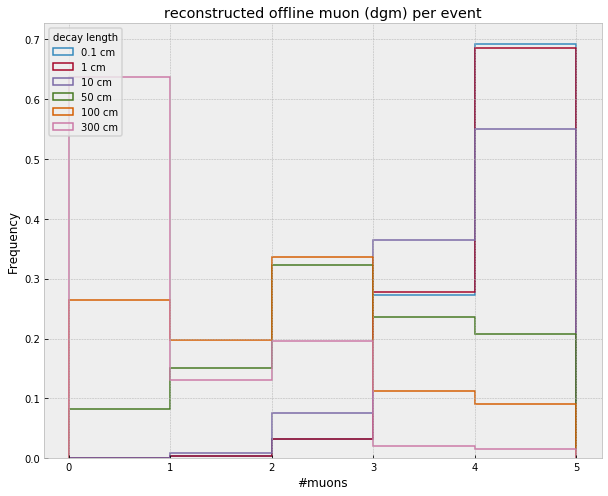

In [28]:
fig, ax = plt.subplots(figsize=(10,8))
plt.rcParams['patch.linewidth'] = 1.5

for k, df in dfs_dgm.items():
#     ax.plot(df['nMatched'].value_counts()/df['nMatched'].count(), 'o', label=f'{k} cm')
    df['nMatched'].plot.hist(bins=5, range=(0,5), ax=ax, label=f'{k} cm', histtype='step', density=True)
    print('%.2fcm #events: %i' % (k, len(df['nMatched'].dropna())))
ax.set_xlabel('#muons')
plt.title('reconstructed offline muon (dgm) per event')
plt.legend(loc='upper left', title='decay length')

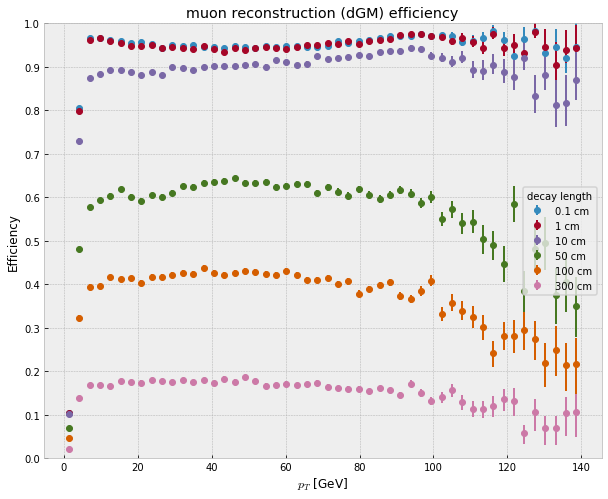

In [29]:
fig,ax = plt.subplots(figsize=(10,8))

for k, df in dfs_dgm.items():
    recoDf = df[['genPt', 'recoPt']].dropna()
    h0 = ROOT.TH1F(f'h0_{k}', '', 50,0,140)
    h1 = ROOT.TH1F(f'h1_{k}', '', 50,0,140)
    for x in df['genPt']: h0.Fill(x)
    for x in recoDf['genPt']: h1.Fill(x)
    
    eff = ROOT.TEfficiency(h1, h0)
    data = extract_teffi(eff)

    ax.errorbar(x=data['x'], y=data['y'], yerr=data['yerr'], fmt='o', label=f'{k} cm')

ax.set_title('muon reconstruction (dGM) efficiency')
ax.set_xlabel('$p_{T}$ [GeV]')
ax.set_ylabel('Efficiency')
ax.yaxis.set_major_locator(plt.MaxNLocator(10))
ax.set_ylim((0,1))
ax.legend(loc='best', title='decay length')

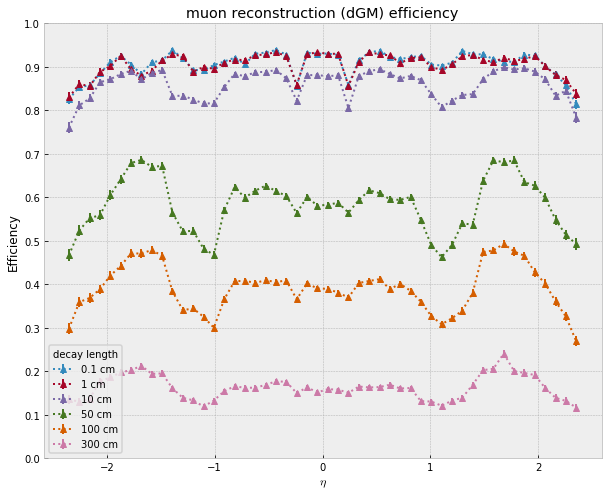

In [30]:
fig,ax = plt.subplots(figsize=(10,8))

for k, df in dfs_dgm.items():
    recoDf = df[['genEta', 'recoEta']].dropna()
    h0 = ROOT.TH1F(f'h0_{k}', '', 50,-2.4,2.4)
    h1 = ROOT.TH1F(f'h1_{k}', '', 50,-2.4,2.4)
    for x in df['genEta']: h0.Fill(x)
    for x in recoDf['genEta']: h1.Fill(x)
    
    eff = ROOT.TEfficiency(h1, h0)
    data = extract_teffi(eff)

    ax.errorbar(x=data['x'], y=data['y'], yerr=data['yerr'], fmt='^:', label=f'{k} cm')

ax.set_title('muon reconstruction (dGM) efficiency')
ax.set_xlabel('$\eta$')
ax.set_ylabel('Efficiency')
ax.yaxis.set_major_locator(plt.MaxNLocator(10))
ax.set_ylim((0,1))
ax.legend(loc='best', title='decay length')

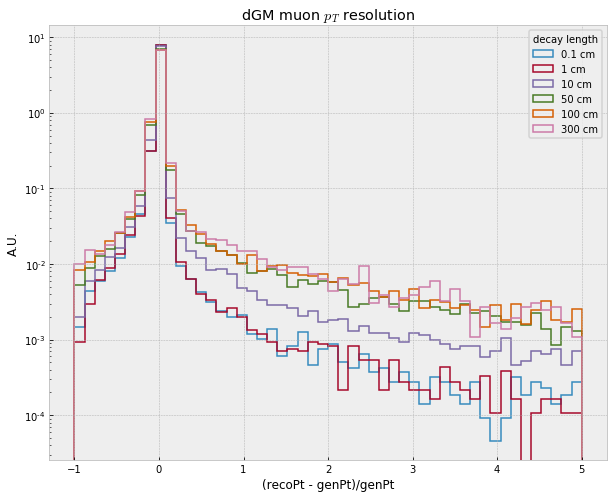

In [34]:
fig,ax = plt.subplots(figsize=(10,8))

for k, df in dfs_dgm.items():
    recoDf = df[['genPt', 'recoPt']].dropna()
    recoDf['reso'] = (recoDf['recoPt'] - recoDf['genPt']) / recoDf['genPt']
    recoDf['reso'].plot.hist(bins=50,range=(-1.,5), label=f'{k} cm', histtype='step',density=True)

ax.set_title('dGM muon $p_{T}$ resolution')
ax.set_xlabel('(recoPt - genPt)/genPt')
ax.set_ylabel('A.U.')
ax.set_yscale('log')
ax.legend(loc='best', title='decay length')

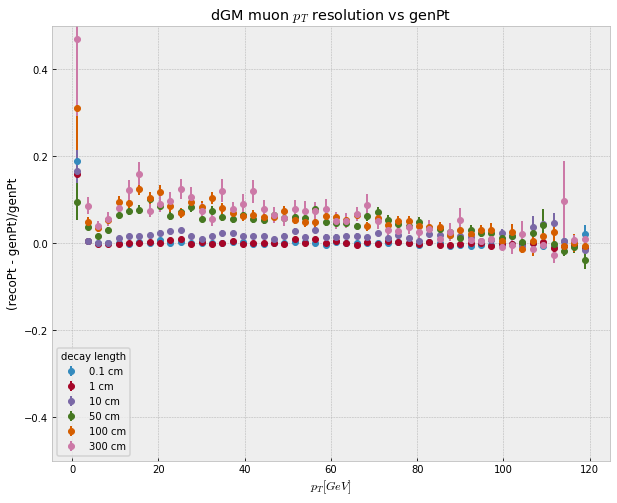

In [59]:
fig,ax = plt.subplots(figsize=(10,8))

for k, df in dfs_dgm.items():
    recoDf = df[['genPt', 'recoPt']].dropna()
    recoDf['reso'] = (recoDf['recoPt'] - recoDf['genPt']) / recoDf['genPt']
    _p = ROOT.TProfile(f'p_{k}', '', 50,0,120,-1,8)
    for index, row in recoDf.iterrows(): _p.Fill(row['genPt'], row['reso'])
    data = extract_tprof(_p)
    ax.errorbar(x=data['x'], y=data['y'], yerr=data['yerr'], label=f'{k} cm', fmt='o')

ax.set_title('dGM muon $p_{T}$ resolution vs genPt')
ax.set_xlabel('$p_{T} [GeV]$')
ax.set_ylabel('(recoPt - genPt)/genPt')
ax.set_ylim((-0.5,0.5))
ax.legend(loc='lower left', title='decay length')

## globalMuons

In [35]:
dfs_gbm = OrderedDict({
    0.1 : uproot.open('../Firefighter/washAOD/test/2018/SIDMmumu_Mps-200_MZp-1p2_ctau-1p20e-03.root')['RECO_gbm/recoEffiForMuTrack'].pandas.df(),
      1 : uproot.open('../Firefighter/washAOD/test/2018/SIDMmumu_Mps-200_MZp-1p2_ctau-0p012.root'   )['RECO_gbm/recoEffiForMuTrack'].pandas.df(),
     10 : uproot.open('../Firefighter/washAOD/test/2018/SIDMmumu_Mps-200_MZp-1p2_ctau-0p12.root'    )['RECO_gbm/recoEffiForMuTrack'].pandas.df(),
     50 : uproot.open('../Firefighter/washAOD/test/2018/SIDMmumu_Mps-200_MZp-1p2_ctau-0p6.root'     )['RECO_gbm/recoEffiForMuTrack'].pandas.df(),
    100 : uproot.open('../Firefighter/washAOD/test/2018/SIDMmumu_Mps-200_MZp-1p2_ctau-1p2.root'     )['RECO_gbm/recoEffiForMuTrack'].pandas.df(),
    300 : uproot.open('../Firefighter/washAOD/test/2018/SIDMmumu_Mps-200_MZp-1p2_ctau-3p6.root'     )['RECO_gbm/recoEffiForMuTrack'].pandas.df()
})

In [36]:
for k, df in dfs_gbm.items():
    df.columns = [x.decode() for x in df.columns]

0.10cm #events: 49379
1.00cm #events: 42237
10.00cm #events: 41593
50.00cm #events: 46931
100.00cm #events: 50910
300.00cm #events: 47659


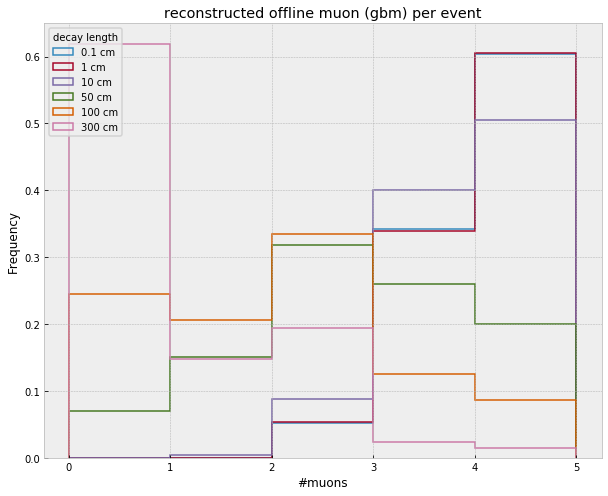

In [38]:
fig, ax = plt.subplots(figsize=(10,8))
plt.rcParams['patch.linewidth'] = 1.5

for k, df in dfs_gbm.items():
#     ax.plot(df['nMatched'].value_counts()/df['nMatched'].count(), 'o', label=f'{k} cm')
    df['nMatched'].plot.hist(bins=5, range=(0,5), ax=ax, label=f'{k} cm', histtype='step', density=True)
    print('%.2fcm #events: %i' % (k, len(df['nMatched'].dropna())))
ax.set_xlabel('#muons')
plt.title('reconstructed offline muon (gbm) per event')
plt.legend(loc='upper left', title='decay length')

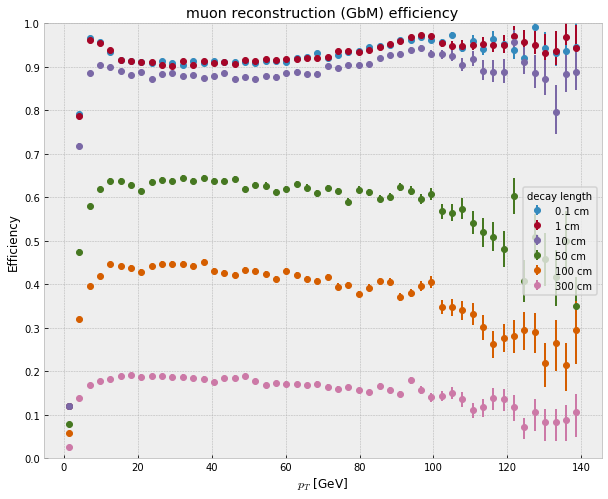

In [39]:
fig,ax = plt.subplots(figsize=(10,8))

for k, df in dfs_gbm.items():
    recoDf = df[['genPt', 'recoPt']].dropna()
    h0 = ROOT.TH1F(f'h0_{k}', '', 50,0,140)
    h1 = ROOT.TH1F(f'h1_{k}', '', 50,0,140)
    for x in df['genPt']: h0.Fill(x)
    for x in recoDf['genPt']: h1.Fill(x)
    
    eff = ROOT.TEfficiency(h1, h0)
    data = extract_teffi(eff)

    ax.errorbar(x=data['x'], y=data['y'], yerr=data['yerr'], fmt='o', label=f'{k} cm')

ax.set_title('muon reconstruction (GbM) efficiency')
ax.set_xlabel('$p_{T}$ [GeV]')
ax.set_ylabel('Efficiency')
ax.yaxis.set_major_locator(plt.MaxNLocator(10))
ax.set_ylim((0,1))
ax.legend(loc='best', title='decay length')

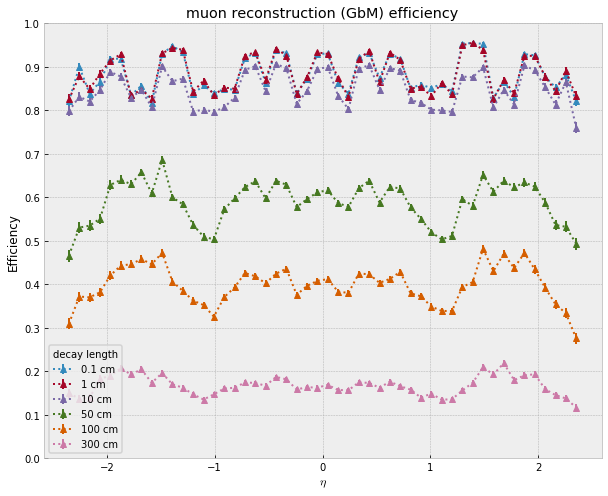

In [40]:
fig,ax = plt.subplots(figsize=(10,8))

for k, df in dfs_gbm.items():
    recoDf = df[['genEta', 'recoEta']].dropna()
    h0 = ROOT.TH1F(f'h0_{k}', '', 50,-2.4,2.4)
    h1 = ROOT.TH1F(f'h1_{k}', '', 50,-2.4,2.4)
    for x in df['genEta']: h0.Fill(x)
    for x in recoDf['genEta']: h1.Fill(x)
    
    eff = ROOT.TEfficiency(h1, h0)
    data = extract_teffi(eff)

    ax.errorbar(x=data['x'], y=data['y'], yerr=data['yerr'], fmt='^:', label=f'{k} cm')

ax.set_title('muon reconstruction (GbM) efficiency')
ax.set_xlabel('$\eta$')
ax.set_ylabel('Efficiency')
ax.yaxis.set_major_locator(plt.MaxNLocator(10))
ax.set_ylim((0,1))
ax.legend(loc='best', title='decay length')

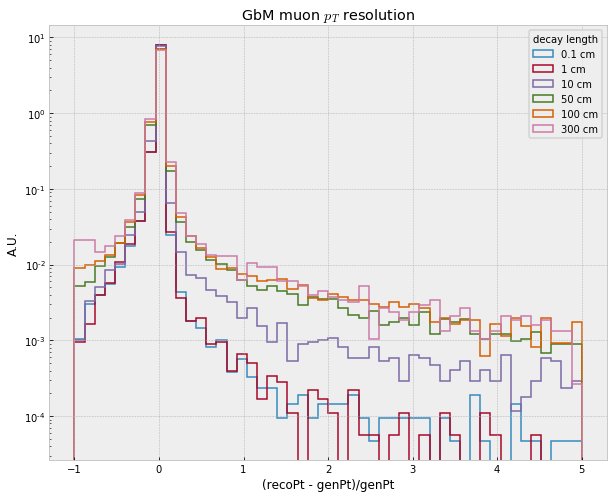

In [41]:
fig,ax = plt.subplots(figsize=(10,8))

for k, df in dfs_gbm.items():
    recoDf = df[['genPt', 'recoPt']].dropna()
    recoDf['reso'] = (recoDf['recoPt'] - recoDf['genPt']) / recoDf['genPt']
    recoDf['reso'].plot.hist(bins=50,range=(-1.,5), label=f'{k} cm', histtype='step',density=True)

ax.set_title('GbM muon $p_{T}$ resolution')
ax.set_xlabel('(recoPt - genPt)/genPt')
ax.set_ylabel('A.U.')
ax.set_yscale('log')
ax.legend(loc='best', title='decay length')

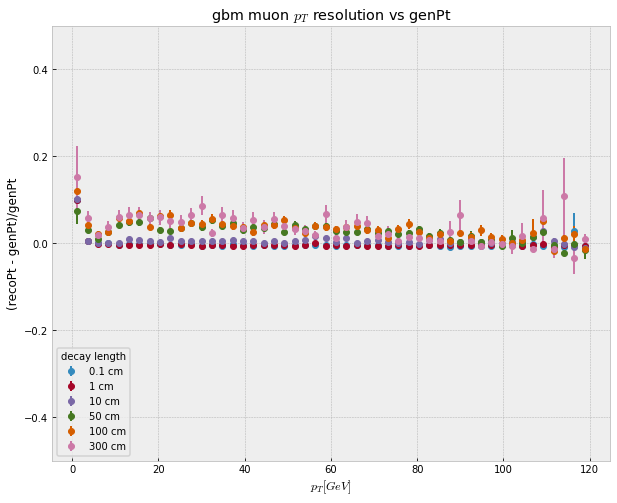

In [58]:
fig,ax = plt.subplots(figsize=(10,8))

for k, df in dfs_gbm.items():
    recoDf = df[['genPt', 'recoPt']].dropna()
    recoDf['reso'] = (recoDf['recoPt'] - recoDf['genPt']) / recoDf['genPt']
    _p = ROOT.TProfile(f'p_{k}', '', 50,0,120,-1,8)
    for index, row in recoDf.iterrows(): _p.Fill(row['genPt'], row['reso'])
    data = extract_tprof(_p)
    ax.errorbar(x=data['x'], y=data['y'], yerr=data['yerr'], label=f'{k} cm', fmt='o')

ax.set_title('gbm muon $p_{T}$ resolution vs genPt')
ax.set_xlabel('$p_{T} [GeV]$')
ax.set_ylabel('(recoPt - genPt)/genPt')
ax.set_ylim((-0.5,0.5))
ax.legend(loc='lower left', title='decay length')

## refittedStandAloneMuons

In [42]:
dfs_rsa = OrderedDict({
    0.1 : uproot.open('../Firefighter/washAOD/test/2018/SIDMmumu_Mps-200_MZp-1p2_ctau-1p20e-03.root')['RECO_rsa/recoEffiForMuTrack'].pandas.df(),
      1 : uproot.open('../Firefighter/washAOD/test/2018/SIDMmumu_Mps-200_MZp-1p2_ctau-0p012.root'   )['RECO_rsa/recoEffiForMuTrack'].pandas.df(),
     10 : uproot.open('../Firefighter/washAOD/test/2018/SIDMmumu_Mps-200_MZp-1p2_ctau-0p12.root'    )['RECO_rsa/recoEffiForMuTrack'].pandas.df(),
     50 : uproot.open('../Firefighter/washAOD/test/2018/SIDMmumu_Mps-200_MZp-1p2_ctau-0p6.root'     )['RECO_rsa/recoEffiForMuTrack'].pandas.df(),
    100 : uproot.open('../Firefighter/washAOD/test/2018/SIDMmumu_Mps-200_MZp-1p2_ctau-1p2.root'     )['RECO_rsa/recoEffiForMuTrack'].pandas.df(),
    300 : uproot.open('../Firefighter/washAOD/test/2018/SIDMmumu_Mps-200_MZp-1p2_ctau-3p6.root'     )['RECO_rsa/recoEffiForMuTrack'].pandas.df()
})

In [43]:
for k, df in dfs_rsa.items():
    df.columns = [x.decode() for x in df.columns]

0.10cm #events: 49379
1.00cm #events: 42237
10.00cm #events: 41593
50.00cm #events: 46931
100.00cm #events: 50910
300.00cm #events: 47659


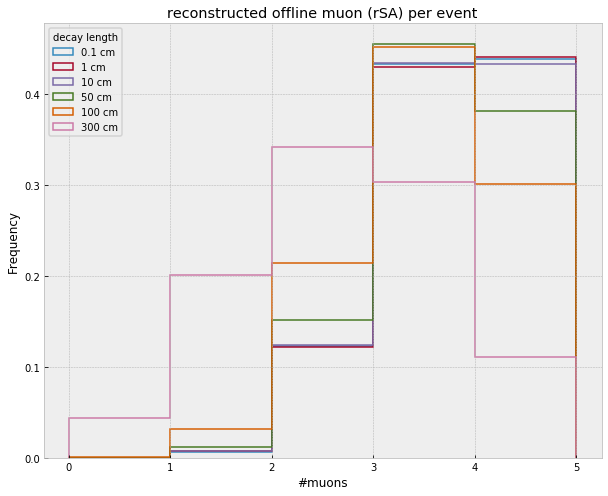

In [44]:
fig, ax = plt.subplots(figsize=(10,8))
plt.rcParams['patch.linewidth'] = 1.5

for k, df in dfs_rsa.items():
#     ax.plot(df['nMatched'].value_counts()/df['nMatched'].count(), 'o', label=f'{k} cm')
    df['nMatched'].plot.hist(bins=5, range=(0,5), ax=ax, label=f'{k} cm', histtype='step', density=True)
    print('%.2fcm #events: %i' % (k, len(df['nMatched'].dropna())))
ax.set_xlabel('#muons')
plt.title('reconstructed offline muon (rSA) per event')
plt.legend(loc='upper left', title='decay length')

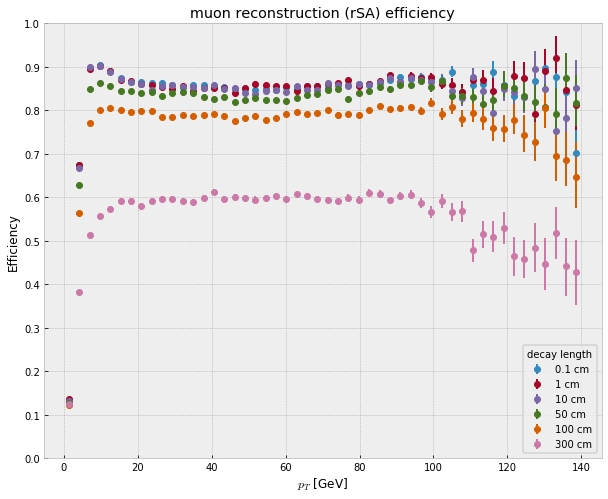

In [45]:
fig,ax = plt.subplots(figsize=(10,8))

for k, df in dfs_rsa.items():
    recoDf = df[['genPt', 'recoPt']].dropna()
    h0 = ROOT.TH1F(f'h0_{k}', '', 50,0,140)
    h1 = ROOT.TH1F(f'h1_{k}', '', 50,0,140)
    for x in df['genPt']: h0.Fill(x)
    for x in recoDf['genPt']: h1.Fill(x)
    
    eff = ROOT.TEfficiency(h1, h0)
    data = extract_teffi(eff)

    ax.errorbar(x=data['x'], y=data['y'], yerr=data['yerr'], fmt='o', label=f'{k} cm')

ax.set_title('muon reconstruction (rSA) efficiency')
ax.set_xlabel('$p_{T}$ [GeV]')
ax.set_ylabel('Efficiency')
ax.yaxis.set_major_locator(plt.MaxNLocator(10))
ax.set_ylim((0,1))
ax.legend(loc='best', title='decay length')

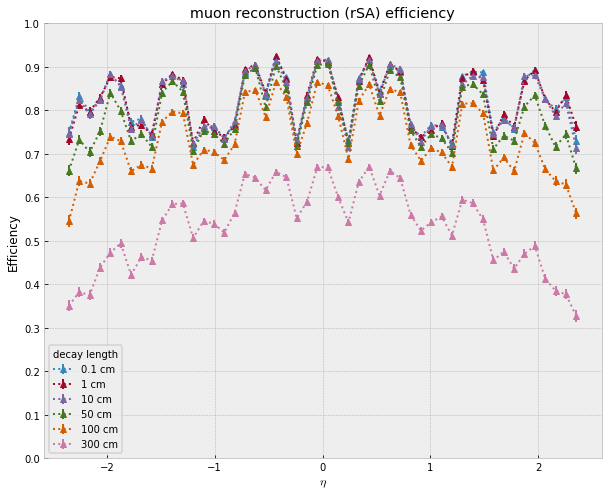

In [46]:
fig,ax = plt.subplots(figsize=(10,8))

for k, df in dfs_rsa.items():
    recoDf = df[['genEta', 'recoEta']].dropna()
    h0 = ROOT.TH1F(f'h0_{k}', '', 50,-2.4,2.4)
    h1 = ROOT.TH1F(f'h1_{k}', '', 50,-2.4,2.4)
    for x in df['genEta']: h0.Fill(x)
    for x in recoDf['genEta']: h1.Fill(x)
    
    eff = ROOT.TEfficiency(h1, h0)
    data = extract_teffi(eff)

    ax.errorbar(x=data['x'], y=data['y'], yerr=data['yerr'], fmt='^:', label=f'{k} cm')

ax.set_title('muon reconstruction (rSA) efficiency')
ax.set_xlabel('$\eta$')
ax.set_ylabel('Efficiency')
ax.yaxis.set_major_locator(plt.MaxNLocator(10))
ax.set_ylim((0,1))
ax.legend(loc='best', title='decay length')

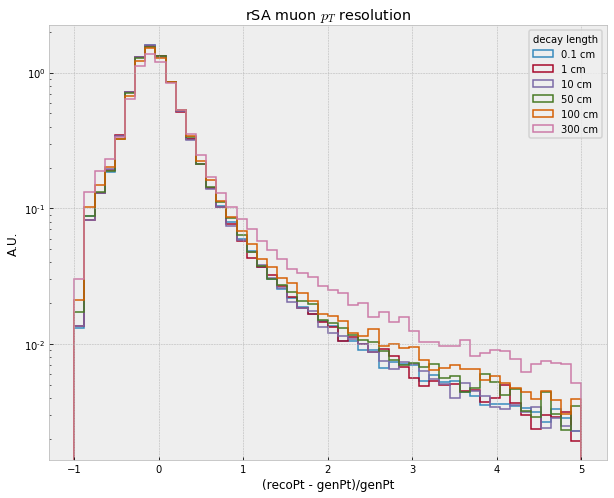

In [48]:
fig,ax = plt.subplots(figsize=(10,8))

for k, df in dfs_rsa.items():
    recoDf = df[['genPt', 'recoPt']].dropna()
    recoDf['reso'] = (recoDf['recoPt'] - recoDf['genPt']) / recoDf['genPt']
    recoDf['reso'].plot.hist(bins=50,range=(-1.,5), label=f'{k} cm', histtype='step',density=True)

ax.set_title('rSA muon $p_{T}$ resolution')
ax.set_xlabel('(recoPt - genPt)/genPt')
ax.set_ylabel('A.U.')
ax.set_yscale('log')
ax.legend(loc='best', title='decay length')

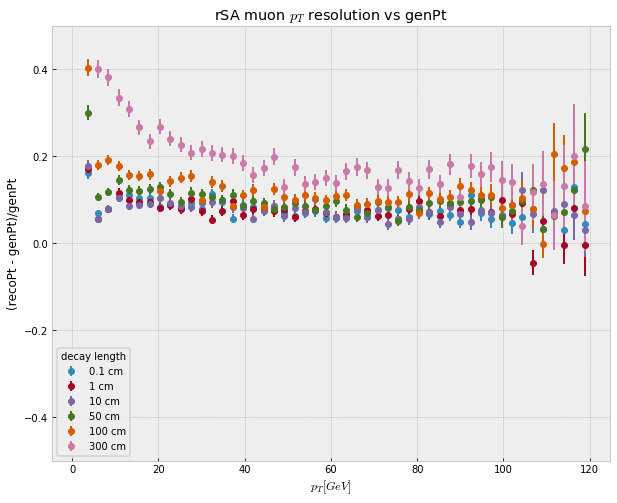

In [60]:
fig,ax = plt.subplots(figsize=(10,8))

for k, df in dfs_rsa.items():
    recoDf = df[['genPt', 'recoPt']].dropna()
    recoDf['reso'] = (recoDf['recoPt'] - recoDf['genPt']) / recoDf['genPt']
    _p = ROOT.TProfile(f'p_{k}', '', 50,0,120,-1,8)
    for index, row in recoDf.iterrows(): _p.Fill(row['genPt'], row['reso'])
    data = extract_tprof(_p)
    ax.errorbar(x=data['x'], y=data['y'], yerr=data['yerr'], label=f'{k} cm', fmt='o')

ax.set_title('rSA muon $p_{T}$ resolution vs genPt')
ax.set_xlabel('$p_{T} [GeV]$')
ax.set_ylabel('(recoPt - genPt)/genPt')
ax.set_ylim((-0.5,0.5))
ax.legend(loc='lower left', title='decay length')